## Binary regression model

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from sklearn.metrics import recall_score, roc_auc_score, accuracy_score, precision_score, roc_curve, auc
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import xgboost
import lightgbm
from imblearn.over_sampling import SMOTE

import pandas as pd
import numpy as np
rnd = 12

import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.enable('default', max_rows=None)

C:\Users\chladek\AppData\Local\Continuum\anaconda3-64\envs\tf\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


DataTransformerRegistry.enable('default')

In [2]:
# load directly preprocessed dataframe
df = pd.read_excel('data/df_task2.xlsx')

In [4]:
# choose only vars we will use in modeling
model_vars = ['customer_id','hour','weekday',
              'prch_freq','prch_last','prch_mean_diff',
              'cart_freq','cart_last','cart_mean_diff',
              'view_freq','view_last','view_mean_diff',
              'sess_freq','sess_last','sess_mean_diff',
              'email_freq','email_last','email_mean_diff']
model_df = df[model_vars]
Y = df.prch_response

In [5]:
df = model_df
#for col in ['weekday']:
#    dummies = pd.get_dummies(df[col], prefix=col)
#    to_del = pd.get_dummies(df[col], prefix=col).columns[0]
#    dummies.drop(labels=to_del, axis=1, inplace=True)
#    df = pd.concat([df,dummies],axis=1)
#    df.drop([col],axis=1, inplace=True)

X = df

# Preprocessing

In [6]:
# create train/test
# validation is always done within cross validation pruning so I bravely/dymbly didn't use explicit validation set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=rnd, stratify=Y)
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)
y_test_transformed = np.hstack((1 - y_test.reshape(y_test.size,1),
                                y_test.reshape(y_test.size,1)))

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(56272, 18) (56272,)
(6253, 18) (6253,)


# <i>0.1 Population descriptive model</i>

In [7]:
# building simple intuitive model based on weekday and hours only
simple = X_train[['hour','weekday']]
simple['response'] = y_train

C:\Users\chladek\AppData\Local\Continuum\anaconda3-64\envs\tf\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [8]:
# take just 50+ delivered timewindows so email are not sent on sunday midnight or so
sub = simple.groupby(['weekday', 'hour']).size().reset_index()
sub.columns
sub = sub[sub[0]>50]

# create unique identifiers
sub['id'] = sub.weekday.astype(str) + 'id' + sub.hour.astype(str)
simple['id'] = simple.weekday.astype(str) + 'id' + simple.hour.astype(str)
sbset = simple[simple.id.isin(sub.id.tolist())]

C:\Users\chladek\AppData\Local\Continuum\anaconda3-64\envs\tf\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
sbset = sbset.groupby(['weekday','hour']).mean().reset_index()
sbset.sort_values(by='response',ascending=False,inplace=True)
sbset.drop_duplicates('weekday',inplace=True)
sbset['id'] = sbset.weekday.astype(str) + 'id' + sbset.hour.astype(str)
X_test['id'] = X_test.weekday.astype(str) + 'id' + X_test.hour.astype(str)
sbset

C:\Users\chladek\AppData\Local\Continuum\anaconda3-64\envs\tf\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,weekday,hour,response,id
3,1,9,0.021148,1id9
32,7,10,0.014388,7id10
19,4,10,0.013514,4id10
24,5,9,0.013043,5id9
13,3,8,0.010870,3id8
6,2,6,0.007580,2id6


In [10]:
# predict 1 if in most freqquent time window of the day otherwise 0

pred = []
for i,row in X_test.iterrows():
    #print(row.id)
    if row.id in(sbset.id.tolist()):
        pred.append(1)
    else:
        pred.append(0)    

In [11]:
print('Test Results')
print("Accuracy: ",accuracy_score(pred, y_test))
print("Recall: ",recall_score(y_test, pred))
print("Precision: ",precision_score(y_test, pred))

Test Results
Accuracy:  0.9085239085239085
Recall:  0.0
Precision:  0.0


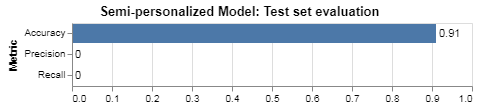

In [12]:
data = pd.DataFrame({
    'a': ['Accuracy','Recall','Precision'],
    'b': [round(accuracy_score(pred, y_test),2), round(recall_score(y_test, pred),2), round(precision_score(y_test, pred),2)]
})

bars = alt.Chart(data).mark_bar().encode(
    alt.X('b',scale=alt.Scale(domain=(0, 1)),axis=alt.Axis(title='')),
    alt.Y('a',axis=alt.Axis(title='Metric')),
).properties(title='Semi-personalized Model: Test set evaluation')

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3
).encode(
    text='b'
)

bars + text

# <i>0.2 Semi-personalized descriptive model</i>

In [13]:
md = X_train[['customer_id','hour','weekday']]
md['response'] = y_train

# determining only useful customers based on sample
# so this basically says unless we saw you prefer any time window on sample bigger than 3 we will use
# population freqs instead
md['freq'] = md[md.response==1].groupby('customer_id')['customer_id'].transform('count')
md = md[md.freq > 3]
md.drop('freq',1,inplace=True)

C:\Users\chladek\AppData\Local\Continuum\anaconda3-64\envs\tf\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\chladek\AppData\Local\Continuum\anaconda3-64\envs\tf\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [14]:
# modes for weekday and hour
mp = md[['customer_id','hour','weekday']].groupby(['customer_id','weekday']).apply(pd.DataFrame.mode).reset_index(drop=True)

In [15]:
mp.dropna(inplace=True)
mp.weekday = mp.weekday.astype(int)
mp['id'] = mp.weekday.astype(str) + 'id' + mp.hour.astype(str)
mp['id2'] = mp.customer_id.astype(str) + ' - ' + mp.weekday.astype(str) + ' - ' + mp.hour.astype(str)
X_test['id2'] = X_test.customer_id.astype(str) + ' - ' + X_test.weekday.astype(str) + ' - ' + X_test.hour.astype(str)
X_test['id'] = X_test.weekday.astype(str) + 'id' + X_test.hour.astype(str)

C:\Users\chladek\AppData\Local\Continuum\anaconda3-64\envs\tf\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\chladek\AppData\Local\Continuum\anaconda3-64\envs\tf\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
# predictions

pred = []
for i,row in X_test.iterrows():
    # check if it is customer's mode hour for the weekday
    if row.id2 in(mp.id2.tolist()):
        pred.append(1)
    # check if it is mode for weekday in the population
    elif row.id in(sbset.id.tolist()):
        pred.append(1)
    else:    
        pred.append(0)    

In [17]:
print('Test Results')
print("Accuracy: ",accuracy_score(pred, y_test))
print("Recall: ",recall_score(y_test, pred))
print("Precision: ",precision_score(y_test, pred))

Test Results
Accuracy:  0.907724292339677
Recall:  0.02564102564102564
Precision:  0.001851851851851852


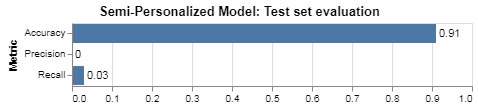

In [18]:
data = pd.DataFrame({
    'a': ['Accuracy','Recall','Precision'],
    'b': [round(accuracy_score(pred, y_test),2), round(recall_score(y_test, pred),2), round(precision_score(y_test, pred),2)]
})

bars = alt.Chart(data).mark_bar().encode(
    alt.X('b',scale=alt.Scale(domain=(0, 1)),axis=alt.Axis(title='')),
    alt.Y('a',axis=alt.Axis(title='Metric')),
).properties(title='Semi-Personalized Model: Test set evaluation')

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3
).encode(
    text='b'
)

bars + text

# SMOTE

In [19]:
# SMOTE
# ref https://jair.org/index.php/jair/article/view/10302  since imblearn page throws e404
# but basically performs under and oversamping at the same time

X_test.drop(['id','id2','customer_id'],1,inplace=True)
X_train.drop(['customer_id'],1,inplace=True)
sm = SMOTE(random_state=rnd, ratio = 1.0)
X_train_sm,Y_train_sm = sm.fit_sample(X_train, y_train)
X_train_sm = pd.DataFrame(X_train_sm)
X_train_sm.columns = X_train.columns
X_train_sm.weekday = X_train_sm.weekday.astype(int)
#X_train_sm.hour = X_train_sm.hour.astype(int)

C:\Users\chladek\AppData\Local\Continuum\anaconda3-64\envs\tf\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Users\chladek\AppData\Local\Continuum\anaconda3-64\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [20]:
X_train_sm.shape

(111836, 17)

In [21]:
y_test = np.ravel(y_test)
y_test_transformed = np.hstack((1 - y_test.reshape(y_test.size,1),
                                y_test.reshape(y_test.size,1)))

# <i>1.1 Decision Tree</i>

In [22]:
X_train_naive = X_train_sm[['weekday','hour']]

In [23]:
# quick DT model based on whole dataset
clf_rf_naive = DecisionTreeClassifier(random_state=rnd,max_depth=3)
clf_rf_naive.fit(X_train_naive, Y_train_sm)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=12,
            splitter='best')

In [24]:
print('Validation Results')
print("Accuracy: ",clf_rf_naive.score(X_test[['weekday','hour']], y_test))
print("Recall: ",recall_score(y_test, clf_rf_naive.predict(X_test[['weekday','hour']])))
print("Precision: ",precision_score(y_test, clf_rf_naive.predict(X_test[['weekday','hour']])))
print("ROC AUC: ",roc_auc_score(y_test_transformed, clf_rf_naive.predict_proba(X_test[['weekday','hour']]),
                                average='weighted'))

Validation Results
Accuracy:  0.3994882456420918
Recall:  0.6410256410256411
Precision:  0.006638343069569836
ROC AUC:  0.502023965734941


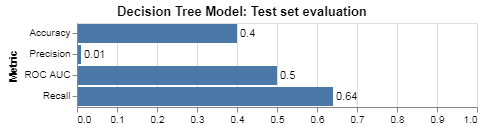

In [25]:
data = pd.DataFrame({
    'a': ['Accuracy','Recall','Precision','ROC AUC'],
    'b': [round(clf_rf_naive.score(X_test[['weekday','hour']], y_test),2),
          round(recall_score(y_test, clf_rf_naive.predict(X_test[['weekday','hour']])),2), 
          round(precision_score(y_test, clf_rf_naive.predict(X_test[['weekday','hour']])),2),
          round(roc_auc_score(y_test_transformed, clf_rf_naive.predict_proba(X_test[['weekday','hour']]),
                                average='weighted'),2)]
})

bars = alt.Chart(data).mark_bar().encode(
    alt.X('b',scale=alt.Scale(domain=(0, 1)),axis=alt.Axis(title='')),
    alt.Y('a',axis=alt.Axis(title='Metric')),
).properties(title='Decision Tree Model: Test set evaluation')

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3
).encode(
    text='b'
)

bars + text

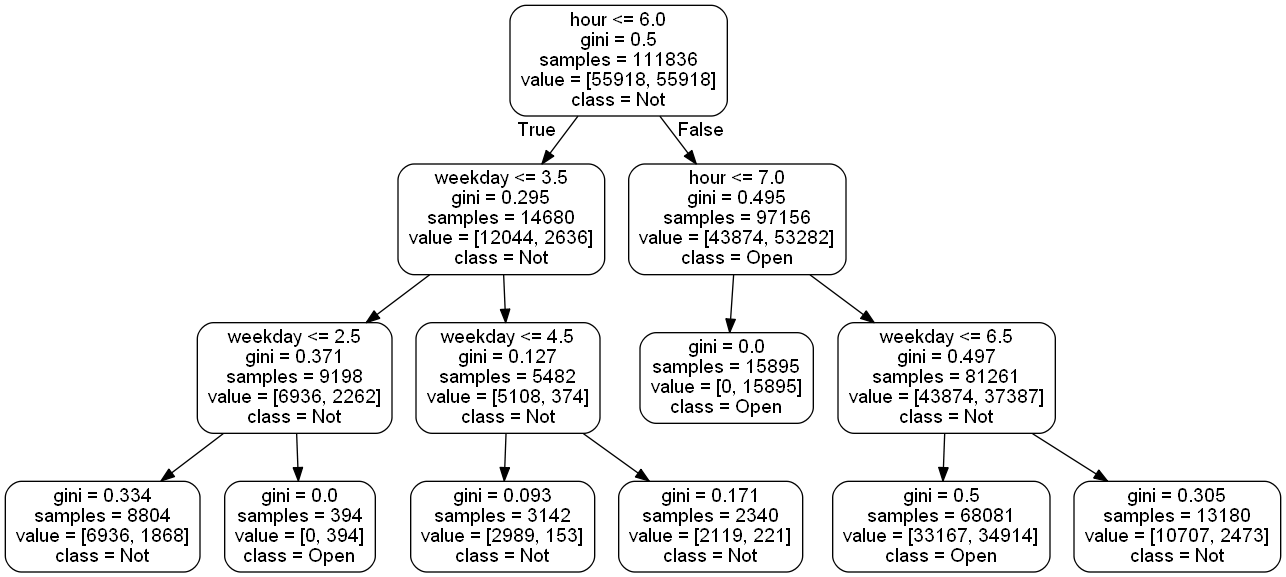

In [30]:
import pydotplus
from sklearn import tree
from IPython.display import Image 
# Create DOT data
dot_data = tree.export_graphviz(clf_rf_naive, out_file=None,
                               feature_names=['weekday','hour'],class_names=['Not','Open'],
                                rounded=True,
                               )

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

# <i>1.2. Tuned Decision Tree (unused)</i>

In [35]:
clf_dt = DecisionTreeClassifier()

CV_SSS = StratifiedShuffleSplit(n_splits=5, test_size=0.33, random_state=rnd)

dt_param_grid = {
                  'max_depth': np.arange(1, 25, 1),
                 }

random_grid_dt_CV = GridSearchCV(clf_dt,
                                        dt_param_grid,
                                        scoring = 'recall',
                                        cv = CV_SSS)#,
                                        #n_iter = 5)
random_grid_dt_CV.fit(X_train_sm, Y_train_sm)
print(random_grid_dt_CV.best_score_)
print(random_grid_dt_CV.best_params_)

0.9544572698206254
{'max_depth': 24}


In [36]:
# quick RF model based on whole dataset
clf_dt = DecisionTreeClassifier(random_state=rnd,max_depth=24)
clf_dt.fit(X_train_naive, Y_train_sm)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=24,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=12,
            splitter='best')

In [37]:
print('Validation Results')
print("Accuracy: ",clf_dt.score(X_test[['weekday','hour']], y_test))
print("Recall: ",recall_score(y_test, clf_dt.predict(X_test[['weekday','hour']])))
print("Precision: ",precision_score(y_test, clf_dt.predict(X_test[['weekday','hour']])))
print("ROC AUC: ",roc_auc_score(y_test_transformed, clf_dt.predict_proba(X_test[['weekday','hour']]),
                                average='weighted'))

Validation Results
Accuracy:  0.9760115144730529
Recall:  0.02564102564102564
Precision:  0.008849557522123894
ROC AUC:  0.5133693149463989


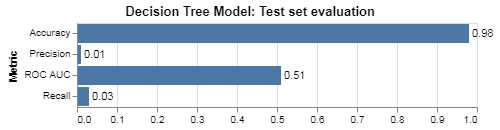

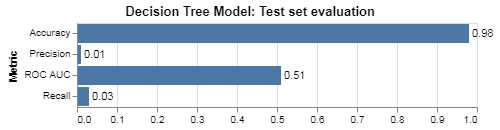

In [38]:
data = pd.DataFrame({
    'a': ['Accuracy','Recall','Precision','ROC AUC'],
    'b': [round(clf_dt.score(X_test[['weekday','hour']], y_test),2),
          round(recall_score(y_test, clf_dt.predict(X_test[['weekday','hour']])),2), 
          round(precision_score(y_test, clf_dt.predict(X_test[['weekday','hour']])),2),
          round(roc_auc_score(y_test_transformed, clf_dt.predict_proba(X_test[['weekday','hour']]),
                                average='weighted'),2)]
})

bars = alt.Chart(data).mark_bar().encode(
    alt.X('b',scale=alt.Scale(domain=(0, 1)),axis=alt.Axis(title='')),
    alt.Y('a',axis=alt.Axis(title='Metric')),
).properties(title='Decision Tree Model: Test set evaluation')

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3
).encode(
    text='b'
)

bars + text

**This is by the way really interesting result even though it was not incorporated to final Report. This is clearly overfitted tree, with tendency to overshoot negative predicitions (hence Recall), was able to obtain 52% AUC ROC and obviously big Accuracy. This ROC can serve as good baseline for other models.**

# <i>1.2.0 Random Forest (starter part not included in Report)</i>

In [39]:
# quick RF model baseline
clf_rf = RandomForestClassifier(n_estimators=300, random_state=rnd,verbose=1)
clf_rf.fit(X_train_sm, Y_train_sm)

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  1.8min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=12, verbose=1, warm_start=False)

In [40]:
print('Test Results')
print("Accuracy: ",clf_rf.score(X_test, y_test))
print("Recall: ",recall_score(y_test, clf_rf.predict(X_test)))
print("Precision: ",precision_score(y_test, clf_rf.predict(X_test)))
print("ROC AUC: ",roc_auc_score(y_test_transformed, clf_rf.predict_proba(X_test), average='weighted'))

Test Results


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.5s finished


Accuracy:  0.9748920518151287


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.4s finished


Recall:  0.02564102564102564


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.4s finished


Precision:  0.008333333333333333
ROC AUC:  0.6675847754862883


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    0.4s finished


In [41]:
var_imp_clf_rf = pd.DataFrame({'vars': X_train_sm.columns,'imp':clf_rf.feature_importances_})
var_imp_clf_rf.sort_values(by='imp',ascending=False)

,vars,imp
0,hour,0.209730
14,email_freq,0.097212
1,weekday,0.093968
11,sess_freq,0.064589
15,email_last,0.064115
8,view_freq,0.062174
10,view_mean_diff,0.052683
16,email_mean_diff,0.052563
9,view_last,0.049533
2,prch_freq,0.047570


In [ ]:
data = pd.DataFrame({
    'a': ['Accuracy','Recall','Precision','ROC AUC'],
    'b': [round(clf_rf_naive.score(X_test, y_test),2),
          round(recall_score(y_test, clf_rf.predict(X_test)),2), 
          round(precision_score(y_test, clf_rf.predict(X_test)),2),
          round(roc_auc_score(y_test_transformed, clf_rf.predict_proba(X_test),
                                average='weighted'),2)]
})

bars = alt.Chart(data).mark_bar().encode(
    alt.X('b',scale=alt.Scale(domain=(0, 1)),axis=alt.Axis(title='')),
    alt.Y('a',axis=alt.Axis(title='Metric')),
).properties(title='Decision Tree Model: Test set evaluation')

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3
).encode(
    text='b'
)

bars + text

# <i>1.2 Random Forest</i>

In [32]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

clf_rf = RandomForestClassifier()

CV_SSS = StratifiedShuffleSplit(n_splits=5, test_size=0.33, random_state=rnd)

rf_param_grid = {
                  'n_estimators': np.arange(20, 400, 20),
                  'max_depth': np.arange(5,100,5),
                 }

random_grid_rf_CV = RandomizedSearchCV(clf_rf,
                                        rf_param_grid,
                                        scoring = 'recall',
                                        cv = CV_SSS,
                                        n_iter = 5)
random_grid_rf_CV.fit(X_train_sm, Y_train_sm)
print(random_grid_rf_CV.best_score_)
print(random_grid_rf_CV.best_params_)

0.9617298000325151
{'n_estimators': 340, 'max_depth': 35}


In [33]:
# quick RF model baseline
clf_rf = RandomForestClassifier(n_estimators=340, max_depth=35, random_state=rnd,verbose=1)
clf_rf.fit(X_train_sm, Y_train_sm)

[Parallel(n_jobs=1)]: Done 340 out of 340 | elapsed:  2.7min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=35, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=340, n_jobs=1,
            oob_score=False, random_state=12, verbose=1, warm_start=False)

In [34]:
print('Test Results')
print("Accuracy: ",clf_rf.score(X_test, y_test))
print("Recall: ",recall_score(y_test, clf_rf.predict(X_test)))
print("Precision: ",precision_score(y_test, clf_rf.predict(X_test)))
print("ROC AUC: ",roc_auc_score(y_test_transformed, clf_rf.predict_proba(X_test), average='weighted'))

Test Results


[Parallel(n_jobs=1)]: Done 340 out of 340 | elapsed:    0.6s finished


Accuracy:  0.9748920518151287


[Parallel(n_jobs=1)]: Done 340 out of 340 | elapsed:    0.4s finished


Recall:  0.02564102564102564


[Parallel(n_jobs=1)]: Done 340 out of 340 | elapsed:    0.5s finished


Precision:  0.008333333333333333
ROC AUC:  0.6646633325905936


[Parallel(n_jobs=1)]: Done 340 out of 340 | elapsed:    0.4s finished


In [45]:
var_imp_clf_rf_final = pd.DataFrame({'vars': X_train_sm.columns,'imp':clf_rf.feature_importances_})
var_imp_clf_rf_final.sort_values(by='imp',ascending=False, inplace=True)
var_imp_clf_rf_final

,vars,imp
0,hour,0.209390
14,email_freq,0.097268
1,weekday,0.093614
11,sess_freq,0.064527
15,email_last,0.064375
8,view_freq,0.062262
10,view_mean_diff,0.052932
16,email_mean_diff,0.052629
9,view_last,0.049614
2,prch_freq,0.047239


[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:    0.5s finished


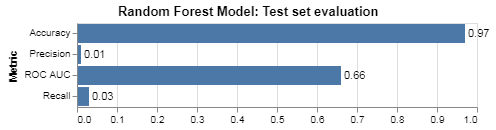

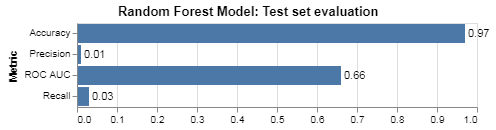

In [46]:
data = pd.DataFrame({
    'a': ['Accuracy','Recall','Precision','ROC AUC'],
    'b': [round(clf_rf.score(X_test, y_test),2),
          round(recall_score(y_test, clf_rf.predict(X_test)),2), 
          round(precision_score(y_test, clf_rf.predict(X_test)),2),
          round(roc_auc_score(y_test_transformed, clf_rf.predict_proba(X_test),
                                average='weighted'),2)]
})

bars = alt.Chart(data).mark_bar().encode(
    alt.X('b',scale=alt.Scale(domain=(0, 1)),axis=alt.Axis(title='')),
    alt.Y('a',axis=alt.Axis(title='Metric')),
).properties(title='Random Forest Model: Test set evaluation')

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3
).encode(
    text='b'
)

bars + text

In [134]:
# output .dot file of random tree from RF to see rootish nodes

estimator = clf_rf.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree5.dot', 
                feature_names = X_train.columns,
                class_names=['Not','Open'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# <i>1.3 Boosted trees - XGBoost</i>

In [294]:
#XGBoost
XGB_Classifier = xgboost.XGBClassifier()

CV_SSS = StratifiedShuffleSplit(n_splits=5, test_size=0.33, random_state=rnd)

xgb_param_grid = {
                  'max_depth': np.arange(2, 40, 2),
                  'learning_rate': np.arange(0.2, 2, 0.2),
                  'n_estimators': np.arange(20, 400, 20),
                  'reg_alpha': np.arange(0, 2, 0.2),
                  'reg_lambda': np.arange(0, 2, 0.2)
                 }

random_grid_XGB_CV = RandomizedSearchCV(XGB_Classifier,
                                        xgb_param_grid,
                                        scoring = 'roc_auc',
                                        cv = CV_SSS,
                                        n_iter = 5)
random_grid_XGB_CV.fit(X_train_sm, Y_train_sm)
print(random_grid_XGB_CV.best_score_)
print(random_grid_XGB_CV.best_params_)

0.938320474250865
{'reg_lambda': 1.8, 'reg_alpha': 1.6, 'n_estimators': 260, 'max_depth': 32, 'learning_rate': 0.4}


In [ ]:
# XGB_Classifier = random_grid_XGB_CV.best_estimator_
XGB_Classifier = xgboost.XGBClassifier(params={'reg_lambda': 1.8, 'reg_alpha': 1.6, 'n_estimators': 260, 
                                               'max_depth': 32, 'learning_rate': 0.4})
XGB_Classifier.fit(X_train_sm, Y_train_sm)
print(XGB_Classifier.feature_importances_)

In [ ]:
#np.argmin(XGB_Classifier.feature_importances_)
y_score = XGB_Classifier.predict_proba(X_test)

In [ ]:
print('Test Results')
print("Accuracy: ",XGB_Classifier.score(X_test, y_test))
print("Recall: ",recall_score(y_test, XGB_Classifier.predict(X_test)))
print("Precision: ",precision_score(y_test, XGB_Classifier.predict(X_test)))
print("ROC AUC: ",roc_auc_score(y_test_transformed, y_score, average='weighted'))

In [ ]:
var_imp_clf_XGB = pd.DataFrame({'vars': X_train_sm.columns,'imp':XGB_Classifier.feature_importances_})
var_imp_clf_XGB.sort_values(by='imp',ascending=False)

In [ ]:
data = pd.DataFrame({
    'a': ['Accuracy','Recall','Precision','ROC AUC'],
    'b': [round(XGB_Classifier.score(X_test, y_test),2),
          round(recall_score(y_test, XGB_Classifier.predict(X_test)),2), 
          round(precision_score(y_test, XGB_Classifier.predict(X_test)),2),
          round(roc_auc_score(y_test_transformed, XGB_Classifier.predict_proba(X_test),
                                average='weighted'),2)]
})

bars = alt.Chart(data).mark_bar().encode(
    alt.X('b',scale=alt.Scale(domain=(0, 1)),axis=alt.Axis(title='')),
    alt.Y('a',axis=alt.Axis(title='Metric')),
).properties(title='Decision Tree Model: Test set evaluation')

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3
).encode(
    text='b'
)

bars + text

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_transformed[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
lw = 2

plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# <i>1.4 LightGBM</i>

In [ ]:
#
# Create the LightGBM data containers
#
categorical_features = [c for c, col in enumerate(X_train_sm.columns) if 'cat' in col]
train_data = lightgbm.Dataset(X_train_sm, label=Y_train_sm, categorical_feature=categorical_features)
test_data = lightgbm.Dataset(X_test, label=y_test)

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'false',
    'boosting': 'gbdt',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': -1

}

CV_SSS = StratifiedShuffleSplit(n_splits=5, test_size=0.33, random_state=None)

lightgbm_param_grid = {
                  'max_depth': np.arange(2, 40, 2),
                  'learning_rate': np.arange(0.2, 2, 0.2),
                  'n_estimators': np.arange(20, 400, 10),
                  'reg_alpha': np.arange(0, 2, 0.2),
                  'reg_lambda': np.arange(0, 2, 0.2),
                  'max_bin': np.arange(300, 600, 5),
                  'num_leaves':np.arange(31,60,1)
                 }

estimator = lightgbm.LGBMClassifier(application='binary',objective='binary',metric='roc_auc',is_unbalance='false',boosting= 'gbdt')

random_grid_GBM_CV = RandomizedSearchCV(estimator,
                                        lightgbm_param_grid,
                                        scoring = 'roc_auc',
                                        cv = CV_SSS,
                                        n_iter = 5)

random_grid_GBM_CV.fit(X_train_sm, Y_train_sm)

print('Best parameters found by random search are:', random_grid_GBM_CV.best_params_)
print('Best score found by random search are:', random_grid_GBM_CV.best_score_)

In [ ]:
# specify your configurations as a dict
params = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'recall',
    'is_unbalance': 'false',
    'boosting': 'gbdt',
    'reg_lambda': 0.6,
    'reg_alpha': 0.2,
    'num_leaves': 44,
    'n_estimators': 140,
    'max_depth': 30,
    'learning_rate': 0.8,
    'verbose': -1,
    'max_bin': 475
}
# fit
gbm = lightgbm.LGBMClassifier(**params)
gbm.fit(X_train_sm, Y_train_sm)

print(gbm.feature_importances_)

#print('Save model...')
# save model to file
#gbm.save_model('model.txt')

print('Start predicting...')
# predict
y_pred = gbm.predict(X_test)
y_score = gbm.predict_proba(X_test)

In [ ]:
print('Test Results')
print("Accuracy: ",gbm.score(X_test, y_test))
print("Recall: ",recall_score(y_test, gbm.predict(X_test)))
print("Precision: ",precision_score(y_test, gbm.predict(X_test)))
print("ROC AUC: ",roc_auc_score(y_test_transformed, y_score, average='weighted'))

In [ ]:
var_imp_clf_rf = pd.DataFrame({'vars': X_train_sm.columns,'imp':gbm.feature_importances_})
var_imp_clf_rf.sort_values(by='imp',ascending=False)

In [ ]:
data = pd.DataFrame({
    'a': ['Accuracy','Recall','Precision','ROC AUC'],
    'b': [round(gbm.score(X_test, y_test),2),
          round(recall_score(y_test, gbm.predict(X_test)),2), 
          round(precision_score(y_test, gbm.predict(X_test)),2),
          round(roc_auc_score(y_test_transformed, gbm.predict_proba(X_test),
                                average='weighted'),2)]
})

bars = alt.Chart(data).mark_bar().encode(
    alt.X('b',scale=alt.Scale(domain=(0, 1)),axis=alt.Axis(title='')),
    alt.Y('a',axis=alt.Axis(title='Metric')),
).properties(title='Decision Tree Model: Test set evaluation')

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3
).encode(
    text='b'
)

bars + text

# <b><i>Iterative Feature importance for tuned RF (unused)</i></b>

In [164]:
# this was just try to iteratively compute feature importance 
# this was done as last step 1.7 but fits here

def score(x1,x2):
    return roc_auc_score(x1,x2)
# defining feature importance
def feat_imp(m, x, y, small_good = True): 

#m: random forest model
#x: matrix of independent variables
#y: output variable
#small__good: True if smaller prediction score is better
    score_list = {} 
    score_list['original'] = score(m.predict(x.values), y) 
    imp = {} 
    for i in range(len(x.columns)):
        rand_idx = np.random.permutation(len(x)) # randomization
        new_coli = x.values[rand_idx, i] 
        new_x = x.copy()            
        new_x[x.columns[i]] = new_coli 
        score_list[x.columns[i]] = score(m.predict(new_x.values), y) 
        imp[x.columns[i]] = score_list['original'] - score_list[x.columns[i]] # comparison with benchmark
    if small_good: 
             return sorted(imp.items(), key=lambda x: x[1]) 
    else: return sorted(imp.items(), key=lambda x: x[1], reverse=True)

In [166]:
#importance = feat_imp(clf_rf, X_train_sm, Y_train_sm)
#importance

# 1.6.5 Feature selection

In [255]:
# create subset suggested by tuned RF feature_importance
# arbitrary threshold 0.045

X_train_fs = X_train_sm[list(var_imp_clf_rf_final[var_imp_clf_rf_final.imp>0.045].vars)]
X_test_fs = X_test[list(var_imp_clf_rf_final[var_imp_clf_rf_final.imp>0.045].vars)]

#### Logistic regression

In [259]:
# Training RF with selected features

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

clf_lr = LogisticRegression()

CV_SSS = StratifiedShuffleSplit(n_splits=5, test_size=0.33, random_state=rnd)

lr_param_grid = {
                  'C':np.logspace(-2, 4, 10),
                  'penalty' : ['l1', 'l2']
                 }

random_grid_lr_CV = GridSearchCV(clf_lr,
                                        lr_param_grid,
                                        scoring = 'roc_auc',
                                        cv = CV_SSS)
random_grid_lr_CV.fit(X_train_fs, Y_train_sm)
print(random_grid_lr_CV.best_score_)
print(random_grid_lr_CV.best_params_)

0.8079873556247362
{'C': 1.0, 'penalty': 'l2'}


In [257]:
# LogisticRegression
clf_lr = LogisticRegression(C=1.0,penalty='l2', random_state=rnd,verbose=1)
clf_lr.fit(X_train_fs, Y_train_sm)

print('Test Results')
print("Accuracy: ",clf_lr.score(X_test_fs, y_test))
print("Recall: ",recall_score(y_test, clf_lr.predict(X_test_fs)))
print("Precision: ",precision_score(y_test, clf_lr.predict(X_test_fs)))
print("ROC AUC: ",roc_auc_score(y_test_transformed, clf_lr.predict_proba(X_test_fs), average='weighted'))

[LibLinear]Test Results
Accuracy:  0.748760594914441
Recall:  0.6360026472534746
Precision:  0.48486377396569125
ROC AUC:  0.7835940066672603


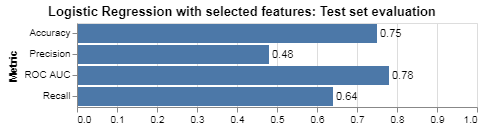

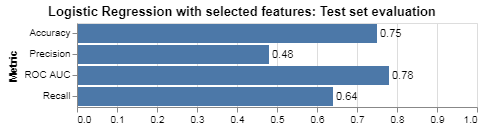

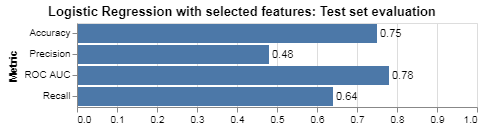

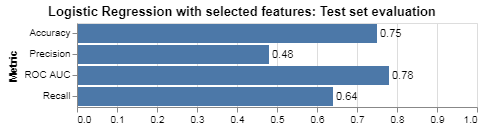

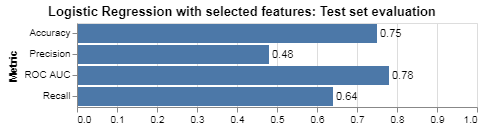

In [258]:
data = pd.DataFrame({
    'a': ['Accuracy','Recall','Precision','ROC AUC'],
    'b': [round(clf_lr.score(X_test_fs, y_test),2),
          round(recall_score(y_test, clf_lr.predict(X_test_fs)),2), 
          round(precision_score(y_test, clf_lr.predict(X_test_fs)),2),
          round(roc_auc_score(y_test_transformed, clf_lr.predict_proba(X_test_fs),
                                average='weighted'),2)]
})

bars = alt.Chart(data).mark_bar().encode(
    alt.X('b',scale=alt.Scale(domain=(0, 1)),axis=alt.Axis(title='')),
    alt.Y('a',axis=alt.Axis(title='Metric')),
).properties(title='Logistic Regression with selected features: Test set evaluation')

text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3
).encode(
    text='b'
)

bars + text

### Random Forest with selected features

In [260]:
clf_rf = RandomForestClassifier()

CV_SSS = StratifiedShuffleSplit(n_splits=5, test_size=0.33, random_state=rnd)

rf_param_grid = {
                  'n_estimators': np.arange(20, 400, 20),
                 }

random_grid_rf_CV = RandomizedSearchCV(clf_rf,
                                        rf_param_grid,
                                        scoring = 'roc_auc',
                                        cv = CV_SSS,
                                        n_iter = 5)
random_grid_rf_CV.fit(X_train_fs, Y_train_sm)
print(random_grid_rf_CV.best_score_)
print(random_grid_rf_CV.best_params_)

0.9182767175338263
{'n_estimators': 380}


In [261]:
# quick RF model baseline
clf_rf = RandomForestClassifier(n_estimators=380, random_state=rnd,verbose=1)
clf_rf.fit(X_train_fs, Y_train_sm)

[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:   55.7s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=380, n_jobs=1,
            oob_score=False, random_state=12, verbose=1, warm_start=False)

In [262]:
print('Test Results')
print("Accuracy: ",clf_rf.score(X_test_fs, y_test))
print("Recall: ",recall_score(y_test, clf_rf.predict(X_test_fs)))
print("Precision: ",recall_score(y_test, clf_rf.predict(X_test_fs)))
print("ROC AUC: ",roc_auc_score(y_test_transformed, clf_rf.predict_proba(X_test_fs), average='weighted'))

Test Results


[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:    0.8s finished


Accuracy:  0.7976971053894131


[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:    0.8s finished


Recall:  0.5268034414295168


[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:    0.7s finished


Precision:  0.5268034414295168
ROC AUC:  0.7908031946800365


[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:    0.7s finished


#### Create interaction terms from reasonable subset used above

In [247]:
poly = PolynomialFeatures(interaction_only=True)
X_train_fs_pre = poly.fit_transform(X_train_fs)
X_train_fs_pre = pd.DataFrame(X_train_fs_pre,columns=poly.get_feature_names(X_train_fs.columns))

X_test_fs_pre = poly.fit_transform(X_test_fs)
X_test_fs_pre = pd.DataFrame(X_test_fs_pre,columns=poly.get_feature_names(X_test_fs.columns))

In [241]:
# I should probably CV the model again but I will use "tuned" already model
clf_rf_inter = RandomForestClassifier(n_estimators=380, random_state=rnd,verbose=1)
clf_rf_inter.fit(X_train_fs_pre, Y_train_sm)

[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:  3.0min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=380, n_jobs=1,
            oob_score=False, random_state=12, verbose=1, warm_start=False)

In [229]:
print('Test Results')
print("Accuracy: ",clf_rf_inter.score(X_test_fs_pre, y_test))
print("Recall: ",recall_score(y_test, clf_rf_inter.predict(X_test_fs_pre)))
print("Precision: ",precision_score(y_test, clf_rf_inter.predict(X_test_fs_pre)))
print("ROC AUC: ",roc_auc_score(y_test_transformed, clf_rf_inter.predict_proba(X_test_fs_pre), average='weighted'))

Test Results


[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:    0.9s finished


Accuracy:  0.8040940348632656


[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:    1.0s finished


Recall:  0.5678358702845797


[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:    0.9s finished


Precision:  0.6
ROC AUC:  0.8266921948170884


[Parallel(n_jobs=1)]: Done 380 out of 380 | elapsed:    0.9s finished


In [242]:
var_imp_clf_rf_inter = pd.DataFrame({'vars': poly.get_feature_names(X_train_fs.columns),'imp':clf_rf_inter.feature_importances_})
var_imp_clf_rf_inter.sort_values(by='imp',ascending=False, inplace=True)
var_imp_clf_rf_inter

,vars,imp
10,email_freq hour,0.098251
1,email_freq,0.093667
8,email_freq email_mean_diff,0.065274
4,hour,0.059455
9,email_freq email_last,0.045703
13,email_freq weekday,0.045665
2,email_mean_diff,0.043232
18,email_mean_diff weekday,0.037598
15,email_mean_diff hour,0.034241
14,email_mean_diff email_last,0.029666


### New iteration of feature selection

In [ ]:
# Training LogisticRegression with selected features
clf_lr = LogisticRegression()

CV_SSS = StratifiedShuffleSplit(n_splits=5, test_size=0.33, random_state=rnd)

lr_param_grid = {
                  'C':np.logspace(0, 4, 10),
                  'penalty' : ['l1', 'l2']
                 }

random_grid_lr_CV = GridSearchCV(clf_lr,
                                        lr_param_grid,
                                        scoring = 'roc_auc',
                                        cv = CV_SSS)
random_grid_lr_CV.fit(X_train_fs_pre, Y_train_sm)
print(random_grid_lr_CV.best_score_)
print(random_grid_lr_CV.best_params_)

In [254]:
# LogisticRegression
clf_lr = LogisticRegression(C=21.544346900318832,penalty='l1', random_state=rnd,verbose=1)
clf_lr.fit(X_train_fs_pre[list(var_imp_clf_rf_inter[var_imp_clf_rf_inter.imp>0.029].vars)], Y_train_sm)

print('Test Results')
print("Accuracy: ",clf_lr.score(X_test_fs_pre[list(var_imp_clf_rf_inter[var_imp_clf_rf_inter.imp>0.029].vars)], y_test))
print("Recall: ",recall_score(y_test, clf_lr.predict(X_test_fs_pre[list(var_imp_clf_rf_inter[var_imp_clf_rf_inter.imp>0.029].vars)])))
print("Precision: ",precision_score(y_test, clf_lr.predict(X_test_fs_pre[list(var_imp_clf_rf_inter[var_imp_clf_rf_inter.imp>0.029].vars)])))
print("ROC AUC: ",roc_auc_score(y_test_transformed, clf_lr.predict_proba(X_test_fs_pre[list(var_imp_clf_rf_inter[var_imp_clf_rf_inter.imp>0.029].vars)]), average='weighted'))

[LibLinear]Test Results
Accuracy:  0.7470014393091317
Recall:  0.613500992720053
Precision:  0.4815584415584416
ROC AUC:  0.7747540111444794
